# Training and Evaluating a Fine-Tuned CNN


## Step 1: Setting Up the PyTorch Environment


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Subset # Important for creating a subset
import os
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(42)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Loading and Customizing a Pre-Trained Model


In [ ]:
# --- Model Setup: ResNet18 for Transfer Learning ---
# Load ResNet18 pre-trained on ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all parameters in the pre-trained model
# We do this because we only want to train the newly added classification head.
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (classifier)
# ResNet18's default 'fc' layer is designed for 1000 ImageNet classes.
# We need to change it to classify into 10 classes for CIFAR-10.
num_ftrs = model.fc.in_features # Get the number of input features to the original FC layer
num_classes = 10 # CIFAR-10 has 10 classes
model.fc = nn.Linear(num_ftrs, num_classes) # Create a new FC layer
model = model.to(device) # Move the model to the chosen device (CPU/GPU)

print("ResNet18 model loaded and modified for 10 classes.")
print(f"Model will run on: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.7MB/s]


ResNet18 model loaded and modified for 10 classes.
Model will run on: cuda


## Step 3: Preparing Data for Fine-Tuning


100%|██████████| 170M/170M [00:18<00:00, 9.05MB/s]



Using a subset of CIFAR-10: 5000 training images, 1000 validation images.

Sample Input Images (from CIFAR-10 subset):


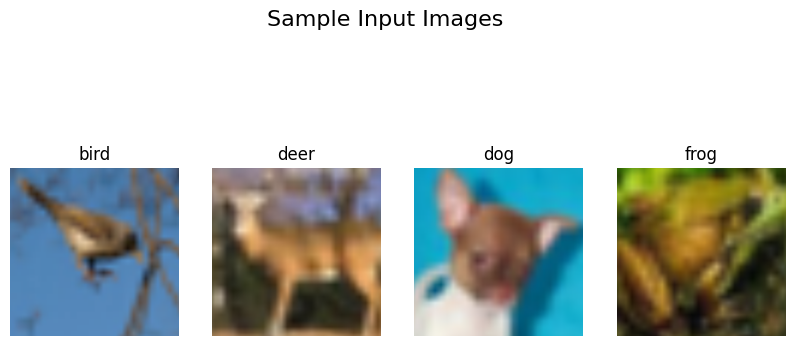

In [ ]:
# --- Data Transformations for CIFAR-10 with ImageNet Preprocessing ---
# The transformations are crucial to match the input expectations of a model
# pre-trained on ImageNet.
transform = transforms.Compose([
    transforms.Resize(256),        # Resize images to 256x256
    transforms.CenterCrop(224),    # Crop the center to 224x224 (ImageNet input size)
    transforms.ToTensor(),         # Convert image to PyTorch tensor (scales to [0,1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# --- Load CIFAR-10 Dataset Subset ---
data_dir = './data'
os.makedirs(data_dir, exist_ok=True) # Ensure data directory exists

# Download and load the FULL CIFAR-10 training dataset first
train_dataset_full = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# Define the size of the subset for quick demonstration
subset_train_size = 5000 # Using 5000 images for training
subset_test_size = 1000 # Using 1000 images for testing/validation

# Create random subsets of the full datasets
# This is key for a faster demo without losing the "real data" aspect
train_indices = torch.randperm(len(train_dataset_full))[:subset_train_size]
train_dataset = Subset(train_dataset_full, train_indices)

test_indices = torch.randperm(len(test_dataset_full))[:subset_test_size]
val_dataset = Subset(test_dataset_full, test_indices) # Using test set as validation for this demo

# Create DataLoaders
# num_workers=0 is typically safer in Colab notebooks to avoid multiprocessing issues
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True if device.type == 'cuda' else False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

print(f"\nUsing a subset of CIFAR-10: {len(train_dataset)} training images, {len(val_dataset)} validation images.")

# --- Input Data Visualization (Optional but good for sanity check) ---
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Change from C, H, W to H, W, C
    # Unnormalize image for correct display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Clip values to [0, 1] range for display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

print("\nSample Input Images (from CIFAR-10 subset):")
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

num_images_to_show = 4
fig = plt.figure(figsize=(10, 5))
for i in range(num_images_to_show):
    ax = fig.add_subplot(1, num_images_to_show, i + 1)
    imshow(images[i])
    # Get class name from the full dataset's classes as Subset doesn't store them directly
    ax.set_title(f"{train_dataset_full.classes[labels[i]]}")
plt.suptitle('Sample Input Images', fontsize=16)
plt.show()

## Step 4: Fine-Tuning the Model


In [ ]:
# --- Training Setup ---
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification
# Only optimize the parameters of the new fully connected layer (model.fc)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 20 # Reduced epochs for faster demonstration

# --- Training Loop ---
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

print("\nStarting Training...")
for epoch in range(num_epochs):
    # Training phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize weights

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1) # Get predictions
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = 100 * train_correct / train_total
    training_losses.append(epoch_train_loss)
    training_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad(): # Disable gradient calculations for validation
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = 100 * val_correct / val_total
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

print("\nTraining finished.")


Starting Training...
Epoch 1/20 - Train Loss: 1.5217, Train Acc: 50.36% | Val Loss: 1.0607, Val Acc: 67.40%
Epoch 2/20 - Train Loss: 0.9673, Train Acc: 69.48% | Val Loss: 0.8815, Val Acc: 71.50%
Epoch 3/20 - Train Loss: 0.8365, Train Acc: 73.10% | Val Loss: 0.8030, Val Acc: 74.20%
Epoch 4/20 - Train Loss: 0.7690, Train Acc: 74.70% | Val Loss: 0.7659, Val Acc: 74.40%
Epoch 5/20 - Train Loss: 0.7270, Train Acc: 75.46% | Val Loss: 0.7385, Val Acc: 74.40%
Epoch 6/20 - Train Loss: 0.7123, Train Acc: 75.90% | Val Loss: 0.7437, Val Acc: 74.30%
Epoch 7/20 - Train Loss: 0.6829, Train Acc: 76.30% | Val Loss: 0.7466, Val Acc: 75.90%
Epoch 8/20 - Train Loss: 0.6630, Train Acc: 77.64% | Val Loss: 0.7097, Val Acc: 75.60%
Epoch 9/20 - Train Loss: 0.6504, Train Acc: 78.78% | Val Loss: 0.7219, Val Acc: 76.20%
Epoch 10/20 - Train Loss: 0.6418, Train Acc: 78.64% | Val Loss: 0.7274, Val Acc: 74.60%
Epoch 11/20 - Train Loss: 0.6392, Train Acc: 77.94% | Val Loss: 0.7228, Val Acc: 74.70%
Epoch 12/20 - Train

## Step 5: Evaluating the Fine-Tuned Model


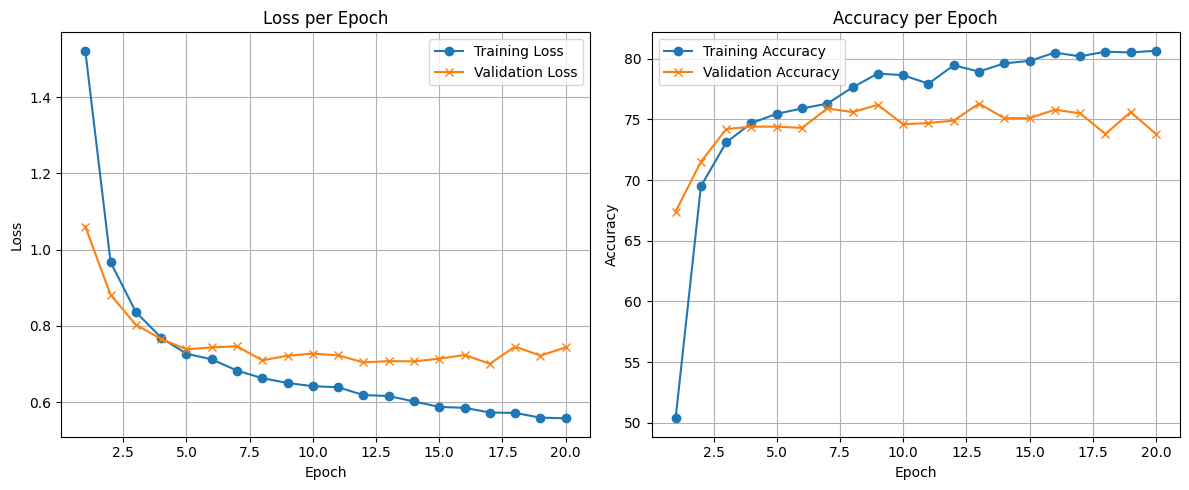

In [ ]:
# --- Visualize Training & Validation Performance ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, marker='x', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, marker='x', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()